### lam data crew



#### 2.Pre-processing
     
    + Analysis Exploratory
    + Data Quality
    + Missing data strategic
 
#### 3.	Feature engineering
    + Using domain knowledge to create features


First approach to detect relevant and most important features

In [1]:
%load_ext google.cloud.bigquery

In [4]:
%%bigquery
select A3,count(distinct(A2)) from 1`lamdatacrew.district` group by A3; 

,A3,f0_
0,central Bohemia,12
1,west Bohemia,10
2,south Moravia,14
3,Prague,1
4,north Moravia,11
5,north Bohemia,10
6,south Bohemia,8
7,east Bohemia,11


In [10]:
%%bigquery card
select * from `lamdatacrew.card`; 

In [11]:
card.head()

,card_id,disp_id,type,issued
0,208,1246,gold,950208 00:00:00
1,3,41,gold,950903 00:00:00
2,261,1629,gold,951109 00:00:00
3,296,1876,gold,951113 00:00:00
4,427,2688,gold,960125 00:00:00


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import time
from sklearn import metrics
from sklearn import neighbors
from sklearn import ensemble
from sklearn import tree
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from pandas.plotting import scatter_matrix
from sklearn.metrics import classification_report
from matplotlib import pyplot as plt
from datetime import datetime, date, time, timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
import matplotlib.ticker as mtick
#import scikitplot as skplt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn import svm
plt.style.use('ggplot')

In [12]:
card.issued = card.issued.str.strip("00:00:00")
card.type = card.type.map({"gold": 2, "classic": 1, "junior": 0})
card.head()

,card_id,disp_id,type,issued
0,208,1246,2,950208
1,3,41,2,950903
2,261,1629,2,951109
3,296,1876,2,951113
4,427,2688,2,960125


In [13]:
%%bigquery account
select * from `lamdatacrew.account`; 

In [18]:
account.date = account.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))
account.head()

,account_id,district_id,frequency,date
0,1132,1,POPLATEK TYDNE,1993-02-03
1,8051,1,POPLATEK TYDNE,1993-02-07
2,11013,1,POPLATEK TYDNE,1993-02-14
3,9403,1,POPLATEK TYDNE,1993-03-27
4,10911,1,POPLATEK TYDNE,1993-05-29


In [26]:
%%bigquery disp
select * from `lamdatacrew.disp`; 

In [20]:
disp.head()

,disp_id,client_id,account_id,type
0,1,1,1,OWNER
1,2,2,2,OWNER
2,4,4,3,OWNER
3,6,6,4,OWNER
4,7,7,5,OWNER


In [21]:
disp.type.describe()

count      5369
unique        2
top       OWNER
freq       4500
Name: type, dtype: object

In [24]:
disp.type.unique()

array(['OWNER', 'DISPONENT'], dtype=object)

In [27]:
disp = disp[disp.type == "OWNER"]
disp.rename(columns={"type": "type_disp"}, inplace=True)
disp.head()

,disp_id,client_id,account_id,type_disp
0,1,1,1,OWNER
1,2,2,2,OWNER
2,4,4,3,OWNER
3,6,6,4,OWNER
4,7,7,5,OWNER


In [29]:
%%bigquery client
select * from `lamdatacrew.client`; 

In [30]:
client.head()

,client_id,birth_number,district_id
0,2,450204,1
1,3,406009,1
2,22,696011,1
3,23,730529,1
4,28,450929,1


In [31]:
client.describe()

,client_id,birth_number,district_id
count,5369.000000,5369.000000,5369.000000
mean,3359.011920,535114.970013,37.310114
std,2832.911984,172895.618429,25.043690
min,1.000000,110820.000000,1.000000
25%,1418.000000,406009.000000,14.000000
50%,2839.000000,540829.000000,38.000000
75%,4257.000000,681013.000000,60.000000
max,13998.000000,875927.000000,77.000000


In [32]:
#data cleaning
client["month"] = client.birth_number.apply(
    lambda x: x // 100 % 100, convert_dtype=True, args=()
)
client["year"] = client.birth_number.apply(
    lambda x: x // 100 // 100, convert_dtype=True, args=()
)
#age determination
client["age"] = 99 - client.year
#detect female from birth due to nature of dataset
client["sex"] = client.month.apply(lambda x: (x - 50) < 0, convert_dtype=True, args=())
client.sex = client.sex.astype(int)  # 0 for female, 1 for male
client.drop(["birth_number", "month", "year"], axis=1, inplace=True)
client.head()

,client_id,district_id,age,sex
0,2,1,54,1
1,3,1,59,0
2,22,1,30,0
3,23,1,26,1
4,28,1,54,1


In [33]:
%%bigquery district
select * from `lamdatacrew.district`; 


In [34]:
# import and update table district
district.drop(["A2", "A3"], axis=1, inplace=True)
district.head()

,A1,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,11,75637,35,36,9,0,7,36.5,9622,0.45,0.59,154,3475,3529
1,27,67298,71,19,10,0,7,43.8,8561,0.65,1.29,110,1029,1127
2,28,72541,66,26,10,0,8,36.9,8594,1.62,2.01,112,1580,1525
3,55,157042,49,70,18,0,9,33.9,8743,1.88,2.43,111,3659,3894
4,1,1204953,0,0,0,1,1,100.0,12541,0.29,0.43,167,85677,99107


In [35]:
%%bigquery order
select * from `lamdatacrew.order`; 

In [36]:
order.describe()

,order_id,account_id,account_to,amount
count,6471.000000,6471.000000,6.471000e+03,6471.000000
mean,33778.197497,2962.302890,4.939904e+07,3280.635698
std,3737.681949,2518.503228,2.888356e+07,2714.475335
min,29401.000000,1.000000,3.990000e+02,1.000000
25%,31187.500000,1223.000000,2.415918e+07,1241.500000
50%,32988.000000,2433.000000,4.975606e+07,2596.000000
75%,34785.500000,3645.500000,7.400045e+07,4613.500000
max,46338.000000,11362.000000,9.999420e+07,14882.000000


In [37]:
order.head()

,order_id,account_id,bank_to,account_to,amount,k_symbol
0,29433,25,AB,79838293,1110.0,
1,29698,196,AB,90261184,4417.0,
2,29750,230,AB,95935326,1527.0,
3,29759,237,AB,58324587,1788.0,
4,29827,282,AB,4248011,802.0,


In [38]:
# import and update table order
order.drop(["bank_to", "account_to", "order_id"], axis=1, inplace=True)
order.k_symbol.fillna("No_symbol")
order.k_symbol = order.k_symbol.str.replace(" ", "No_symbol")
order = order.groupby(["account_id", "k_symbol"]).mean().unstack()
order = order.fillna(0)
order.columns = order.columns.droplevel()
order.reset_index(level="account_id", col_level=1, inplace=True)
order.rename_axis("", axis="columns", inplace=True)
order.rename(
    index=None,
    columns={
        "LEASING": "order_amount_LEASING",
        "No_symbol": "order_amount_No_symbol",
        "POJISTNE": "order_amount_POJISTNE",
        "SIPO": "order_amount_SIPO",
        "UVER": "order_amount_UVER",
    },
    inplace=True,
)
order.head()

,account_id,order_amount_LEASING,order_amount_No_symbol,order_amount_POJISTNE,order_amount_SIPO,order_amount_UVER
0,1,0.0,0.0,0.0,2452.0,0.0
1,2,0.0,0.0,0.0,7266.0,3372.7
2,3,0.0,327.0,3539.0,1135.0,0.0
3,4,0.0,0.0,0.0,1681.5,0.0
4,5,0.0,0.0,0.0,2668.0,0.0


In [41]:

# import and update table loan

loan.date = loan.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))
loan.head()

,loan_id,account_id,date,amount,duration,payments,status
0,7284,11265,1993-09-15,52788,12,4399.0,A
1,6456,7123,1993-12-09,47016,12,3918.0,A
2,6820,9034,1993-12-16,38148,12,3179.0,A
3,6876,9236,1993-12-21,86616,12,7218.0,A
4,5479,2486,1994-01-10,24516,12,2043.0,A


In [42]:
%%bigquery trans
select * from `lamdatacrew.trans`; 



In [43]:

trans.loc[trans.k_symbol == "", "k_symbol"] = trans[
    trans.k_symbol == ""
].k_symbol.apply(lambda x: "k_symbol_missing")
trans.loc[trans.k_symbol == " ", "k_symbol"] = trans[
    trans.k_symbol == " "
].k_symbol.apply(lambda x: "k_symbol_missing")
loan_account_id = loan.loc[:, ["account_id"]]
trans = loan_account_id.merge(trans, how="left", on="account_id")
trans.date = trans.date.apply(lambda x: pd.to_datetime(str(x), format="%y%m%d"))
trans.head()

,account_id,trans_id,date,type,operation,amount,balance,k_symbol,bank,account
0,11265,3528743,1993-02-28,PRIJEM,,43.9,18461.8,UROK,None,None
1,11265,3528744,1993-03-31,PRIJEM,,92.4,25372.3,UROK,None,None
2,11265,3528745,1993-04-30,PRIJEM,,112.2,28302.5,UROK,None,None
3,11265,3528746,1993-05-31,PRIJEM,,121.6,30042.1,UROK,None,None
4,11265,3528747,1993-06-30,PRIJEM,,95.3,19231.4,UROK,None,None


In [44]:

# create temp table trans_pv_k_symbol
trans_pv_k_symbol = trans.pivot_table(
    values=["amount", "balance"], index=["trans_id"], columns="k_symbol"
)
trans_pv_k_symbol.fillna(0, inplace=True)
trans_pv_k_symbol.columns = ["_".join(col) for col in trans_pv_k_symbol.columns]
trans_pv_k_symbol = trans_pv_k_symbol.reset_index()
trans_pv_k_symbol = trans.iloc[:, :3].merge(
    trans_pv_k_symbol, how="left", on="trans_id"
)
trans_pv_k_symbol.head()

,account_id,trans_id,date,amount_POJISTNE,amount_SANKC. UROK,amount_SIPO,amount_SLUZBY,amount_UROK,amount_UVER,amount_k_symbol_missing,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing
0,11265,3528743,1993-02-28,0.0,0.0,0.0,0.0,43.9,0.0,0.0,0.0,0.0,0.0,0.0,18461.8,0.0,0.0
1,11265,3528744,1993-03-31,0.0,0.0,0.0,0.0,92.4,0.0,0.0,0.0,0.0,0.0,0.0,25372.3,0.0,0.0
2,11265,3528745,1993-04-30,0.0,0.0,0.0,0.0,112.2,0.0,0.0,0.0,0.0,0.0,0.0,28302.5,0.0,0.0
3,11265,3528746,1993-05-31,0.0,0.0,0.0,0.0,121.6,0.0,0.0,0.0,0.0,0.0,0.0,30042.1,0.0,0.0
4,11265,3528747,1993-06-30,0.0,0.0,0.0,0.0,95.3,0.0,0.0,0.0,0.0,0.0,0.0,19231.4,0.0,0.0


In [45]:
# create temp table get_date_loan_trans
get_date_loan_trans = pd.merge(
    loan,
    account,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_loan", "_account"),
    copy=True,
    indicator=False,
    validate=None,
)
get_date_loan_trans = pd.merge(
    get_date_loan_trans,
    trans,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_account", "_trans"),
    copy=True,
    indicator=False,
    validate=None,
)

In [46]:
get_date_loan_trans.head()

,loan_id,account_id,date_loan,amount_account,duration,payments,status,district_id,frequency,date_account,trans_id,date,type,operation,amount_trans,balance,k_symbol,bank,account
0,7284,11265,1993-09-15,52788,12,4399.0,A,15,POPLATEK MESICNE,1993-01-14,3528743,1993-02-28,PRIJEM,,43.9,18461.8,UROK,None,None
1,7284,11265,1993-09-15,52788,12,4399.0,A,15,POPLATEK MESICNE,1993-01-14,3528744,1993-03-31,PRIJEM,,92.4,25372.3,UROK,None,None
2,7284,11265,1993-09-15,52788,12,4399.0,A,15,POPLATEK MESICNE,1993-01-14,3528745,1993-04-30,PRIJEM,,112.2,28302.5,UROK,None,None
3,7284,11265,1993-09-15,52788,12,4399.0,A,15,POPLATEK MESICNE,1993-01-14,3528746,1993-05-31,PRIJEM,,121.6,30042.1,UROK,None,None
4,7284,11265,1993-09-15,52788,12,4399.0,A,15,POPLATEK MESICNE,1993-01-14,3528747,1993-06-30,PRIJEM,,95.3,19231.4,UROK,None,None


In [47]:

# update table get_date_loan_trans to get the date between loan_date and trans_date.
get_date_loan_trans["date_loan_trans"] = (
    get_date_loan_trans.date_loan - get_date_loan_trans.date
)
get_date_loan_trans[["date_loan_trans"]] = get_date_loan_trans[
    ["date_loan_trans"]
].astype(str)
get_date_loan_trans.date_loan_trans = get_date_loan_trans.date_loan_trans.str.strip(
    " days 00:00:00.000000000"
)
get_date_loan_trans.date_loan_trans = pd.to_numeric(
    get_date_loan_trans.date_loan_trans.str.strip(" days +")
)
get_date_loan_trans.head()

,loan_id,account_id,date_loan,amount_account,duration,payments,status,district_id,frequency,date_account,trans_id,date,type,operation,amount_trans,balance,k_symbol,bank,account,date_loan_trans
0,7284,11265,1993-09-15,52788,12,4399.0,A,15,POPLATEK MESICNE,1993-01-14,3528743,1993-02-28,PRIJEM,,43.9,18461.8,UROK,None,None,199.0
1,7284,11265,1993-09-15,52788,12,4399.0,A,15,POPLATEK MESICNE,1993-01-14,3528744,1993-03-31,PRIJEM,,92.4,25372.3,UROK,None,None,168.0
2,7284,11265,1993-09-15,52788,12,4399.0,A,15,POPLATEK MESICNE,1993-01-14,3528745,1993-04-30,PRIJEM,,112.2,28302.5,UROK,None,None,138.0
3,7284,11265,1993-09-15,52788,12,4399.0,A,15,POPLATEK MESICNE,1993-01-14,3528746,1993-05-31,PRIJEM,,121.6,30042.1,UROK,None,None,107.0
4,7284,11265,1993-09-15,52788,12,4399.0,A,15,POPLATEK MESICNE,1993-01-14,3528747,1993-06-30,PRIJEM,,95.3,19231.4,UROK,None,None,77.0


In [48]:
# create temp table temp_90_mean to create new feature
temp_90_mean = get_date_loan_trans[
    (get_date_loan_trans["date_loan_trans"] >= 0)
    & (get_date_loan_trans["date_loan_trans"] < 90)
]
temp_90_mean = temp_90_mean.drop(["trans_id", "k_symbol"], axis=1)
temp_90_mean = temp_90_mean.groupby(["loan_id"], as_index=None).mean()
temp_90_mean = temp_90_mean.loc[:, ["loan_id", "balance"]]
temp_90_mean.rename(
    index=None, columns={"balance": "avg_balance_3M_befroe_loan"}, inplace=True
)

In [49]:
# create temp table temp_30_mean to create new feature
temp_30_mean = get_date_loan_trans[
    (get_date_loan_trans["date_loan_trans"] >= 0)
    & (get_date_loan_trans["date_loan_trans"] < 30)
]
temp_30_mean = temp_30_mean.drop(["trans_id", "k_symbol"], axis=1)
temp_30_mean = temp_30_mean.groupby(["loan_id"], as_index=None).mean()
temp_30_mean = temp_30_mean.loc[:, ["loan_id", "balance"]]
temp_30_mean.rename(
    index=None, columns={"balance": "avg_balance_1M_befroe_loan"}, inplace=True
)

In [50]:

# create temp table temp_trans_freq to create new feature
temp_before = get_date_loan_trans[(get_date_loan_trans["date_loan_trans"] >= 0)]
temp_trans_freq = (
    temp_before.loc[:, ["loan_id", "trans_id"]]
    .groupby(["loan_id"], as_index=None)
    .count()
)
temp_trans_freq.rename(index=None, columns={"trans_id": "trans_freq"}, inplace=True)
temp_before = temp_before.drop(["trans_id", "k_symbol"], axis=1)

In [51]:

# create temp table temp_balance_min & temp_balance_mean to create new features
temp_balance_min = (
    temp_before.groupby(["loan_id"], as_index=None).min().loc[:, ["loan_id", "balance"]]
)
temp_balance_min.rename(
    index=None, columns={"balance": "min_balance_befroe_loan"}, inplace=True
)

temp_balance_mean = (
    temp_before.groupby(["loan_id"], as_index=None)
    .mean()
    .loc[:, ["loan_id", "amount_trans", "balance"]]
)
temp_balance_mean.rename(
    index=None,
    columns={
        "amount_trans": "avg_amount_trans_before_loan",
        "balance": "avg_balance_before_loan",
    },
    inplace=True,
)

In [53]:
# create temp table times_balance_below_500 & times_balance_below_5K to create new features
times_balance_below_500 = temp_before[temp_before.balance < 500]
times_balance_below_500 = (
    times_balance_below_500.groupby(["loan_id"], as_index=None)
    .count()
    .loc[:, ["loan_id", "balance"]]
)
times_balance_below_500 = times_balance_below_500[times_balance_below_500.balance > 1]
times_balance_below_500.rename(
    index=str, columns={"balance": "times_balance_below_500"}, inplace=True
)

times_balance_below_5K = temp_before[temp_before.balance < 5000]
times_balance_below_5K = (
    times_balance_below_5K.groupby(["loan_id"], as_index=None)
    .count()
    .loc[:, ["loan_id", "balance"]]
)
times_balance_below_5K = times_balance_below_5K[times_balance_below_5K.balance > 1]
times_balance_below_5K.rename(
    index=str, columns={"balance": "times_balance_below_5K"}, inplace=True
)

In [54]:
# create temp table merge_loan_trans to merge the temp features above into one temp table
merge_loan_trans = loan.merge(
    temp_90_mean, how="left", on="loan_id", suffixes=("_loan", "_trans")
)
merge_loan_trans = merge_loan_trans.merge(temp_30_mean, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(temp_trans_freq, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(temp_balance_min, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(temp_balance_mean, how="left", on="loan_id")
merge_loan_trans = merge_loan_trans.merge(
    times_balance_below_500, how="left", on="loan_id"
)
merge_loan_trans = merge_loan_trans.merge(
    times_balance_below_5K, how="left", on="loan_id"
)

In [58]:
#'B' stands for contract finished, loan not payed,
# 'D' stands for running contract, client in debt
loan_BorD = loan[(loan.status == "D") | (loan.status == "B")]
print(len(loan_BorD))


76


In [56]:

temp = times_balance_below_500.merge(
    loan,
    how="inner",
    on="loan_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_x", "_y"),
    copy=True,
    indicator=False,
    validate=None,
)

temp.status.value_counts()

D    17
B     7
A     2
Name: status, dtype: int64

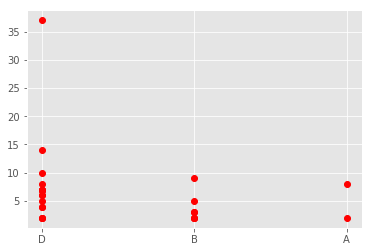

In [57]:
plt.plot(temp.status, temp.times_balance_below_500, "ro")

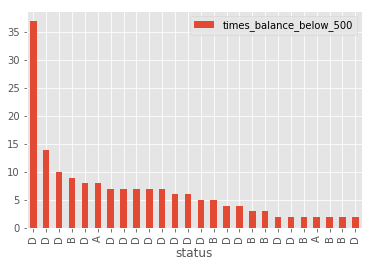

In [59]:
temp.sort_values("times_balance_below_500", ascending=False).plot(
    x="status", y="times_balance_below_500", kind="bar"
)

In [60]:
temp.head()

,loan_id,times_balance_below_500,account_id,date,amount,duration,payments,status
0,4988,2,103,1997-12-06,265320,36,7370.0,D
1,5045,2,347,1995-05-01,187224,24,7801.0,B
2,5126,2,790,1994-07-24,208128,48,4336.0,B
3,5128,7,808,1996-04-11,215616,48,4492.0,D
4,5208,4,1247,1995-03-16,99696,48,2077.0,D


In [61]:
t = loan.loc[:, ["payments", "status"]]
t.head(3)

,payments,status
0,4399.0,A
1,3918.0,A
2,3179.0,A


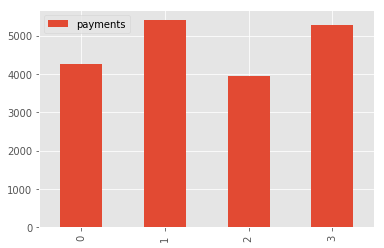

In [62]:
t = t.groupby(["status"], as_index=None).mean()
t.plot(kind="bar")

### Merge tables


In [63]:
df = pd.merge(
    merge_loan_trans,
    account,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_loan", "_account"),
    copy=True,
    indicator=False,
    validate=None,
)

In [64]:
df.head()

,loan_id,account_id,date_loan,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,min_balance_befroe_loan,avg_amount_trans_before_loan,avg_balance_before_loan,times_balance_below_500,times_balance_below_5K,district_id,frequency,date_account
0,7284,11265,1993-09-15,52788,12,4399.0,A,20615.732000,20471.962500,43,1000.0,3714.897674,22198.179070,NaN,NaN,15,POPLATEK MESICNE,1993-01-14
1,6456,7123,1993-12-09,47016,12,3918.0,A,69408.845833,66679.309091,42,200.0,12252.223810,60382.085714,NaN,NaN,64,POPLATEK PO OBRATU,1993-04-14
2,6820,9034,1993-12-16,38148,12,3179.0,A,41406.252632,36175.655556,29,900.0,8369.555172,37462.093103,NaN,NaN,1,POPLATEK MESICNE,1993-06-28
3,6876,9236,1993-12-21,86616,12,7218.0,A,29641.558333,36958.900000,15,800.0,5323.546667,25714.046667,NaN,NaN,11,POPLATEK MESICNE,1993-08-18
4,5479,2486,1994-01-10,24516,12,2043.0,A,69396.845161,63994.557143,73,200.0,16201.558904,55582.226027,2.0,3.0,1,POPLATEK MESICNE,1993-02-27


In [65]:
df = pd.merge(
    df,
    order,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_a", "_order"),
    copy=True,
    indicator=False,
    validate=None,
)
df.head()

,loan_id,account_id,date_loan,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,...,times_balance_below_500,times_balance_below_5K,district_id,frequency,date_account,order_amount_LEASING,order_amount_No_symbol,order_amount_POJISTNE,order_amount_SIPO,order_amount_UVER
0,7284,11265,1993-09-15,52788,12,4399.0,A,20615.732000,20471.962500,43,...,NaN,NaN,15,POPLATEK MESICNE,1993-01-14,0.0,2607.0,0.0,506.0,4399.0
1,6456,7123,1993-12-09,47016,12,3918.0,A,69408.845833,66679.309091,42,...,NaN,NaN,64,POPLATEK PO OBRATU,1993-04-14,0.0,0.0,0.0,14581.0,3918.2
2,6820,9034,1993-12-16,38148,12,3179.0,A,41406.252632,36175.655556,29,...,NaN,NaN,1,POPLATEK MESICNE,1993-06-28,0.0,621.0,9115.0,4697.0,3179.0
3,6876,9236,1993-12-21,86616,12,7218.0,A,29641.558333,36958.900000,15,...,NaN,NaN,11,POPLATEK MESICNE,1993-08-18,0.0,2276.0,0.0,2239.0,7218.0
4,5479,2486,1994-01-10,24516,12,2043.0,A,69396.845161,63994.557143,73,...,2.0,3.0,1,POPLATEK MESICNE,1993-02-27,0.0,0.0,0.0,0.0,2043.0


In [66]:

df = pd.merge(
    df,
    disp,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_b", "_disp"),
    copy=True,
    indicator=False,
    validate=None,
)
df.head()

,loan_id,account_id,date_loan,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,...,frequency,date_account,order_amount_LEASING,order_amount_No_symbol,order_amount_POJISTNE,order_amount_SIPO,order_amount_UVER,disp_id,client_id,type_disp
0,7284,11265,1993-09-15,52788,12,4399.0,A,20615.732000,20471.962500,43,...,POPLATEK MESICNE,1993-01-14,0.0,2607.0,0.0,506.0,4399.0,13537,13845,OWNER
1,6456,7123,1993-12-09,47016,12,3918.0,A,69408.845833,66679.309091,42,...,POPLATEK PO OBRATU,1993-04-14,0.0,0.0,0.0,14581.0,3918.2,8598,8598,OWNER
2,6820,9034,1993-12-16,38148,12,3179.0,A,41406.252632,36175.655556,29,...,POPLATEK MESICNE,1993-06-28,0.0,621.0,9115.0,4697.0,3179.0,10818,11126,OWNER
3,6876,9236,1993-12-21,86616,12,7218.0,A,29641.558333,36958.900000,15,...,POPLATEK MESICNE,1993-08-18,0.0,2276.0,0.0,2239.0,7218.0,11064,11372,OWNER
4,5479,2486,1994-01-10,24516,12,2043.0,A,69396.845161,63994.557143,73,...,POPLATEK MESICNE,1993-02-27,0.0,0.0,0.0,0.0,2043.0,3001,3001,OWNER


In [67]:
df = pd.merge(
    df,
    card,
    how="left",
    on="disp_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_c", "_card"),
    copy=True,
    indicator=False,
    validate=None,
)
df.head()

,loan_id,account_id,date_loan,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,...,order_amount_No_symbol,order_amount_POJISTNE,order_amount_SIPO,order_amount_UVER,disp_id,client_id,type_disp,card_id,type,issued
0,7284,11265,1993-09-15,52788,12,4399.0,A,20615.732000,20471.962500,43,...,2607.0,0.0,506.0,4399.0,13537,13845,OWNER,NaN,NaN,NaN
1,6456,7123,1993-12-09,47016,12,3918.0,A,69408.845833,66679.309091,42,...,0.0,0.0,14581.0,3918.2,8598,8598,OWNER,NaN,NaN,NaN
2,6820,9034,1993-12-16,38148,12,3179.0,A,41406.252632,36175.655556,29,...,621.0,9115.0,4697.0,3179.0,10818,11126,OWNER,NaN,NaN,NaN
3,6876,9236,1993-12-21,86616,12,7218.0,A,29641.558333,36958.900000,15,...,2276.0,0.0,2239.0,7218.0,11064,11372,OWNER,NaN,NaN,NaN
4,5479,2486,1994-01-10,24516,12,2043.0,A,69396.845161,63994.557143,73,...,0.0,0.0,0.0,2043.0,3001,3001,OWNER,NaN,NaN,NaN


In [68]:
df = pd.merge(
    df,
    client,
    how="left",
    on="client_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_d", "_client"),
    copy=True,
    indicator=False,
    validate=None,
)

In [69]:
df.head()

,loan_id,account_id,date_loan,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,...,order_amount_UVER,disp_id,client_id,type_disp,card_id,type,issued,district_id_client,age,sex
0,7284,11265,1993-09-15,52788,12,4399.0,A,20615.732000,20471.962500,43,...,4399.0,13537,13845,OWNER,NaN,NaN,NaN,15,26,1
1,6456,7123,1993-12-09,47016,12,3918.0,A,69408.845833,66679.309091,42,...,3918.2,8598,8598,OWNER,NaN,NaN,NaN,46,42,0
2,6820,9034,1993-12-16,38148,12,3179.0,A,41406.252632,36175.655556,29,...,3179.0,10818,11126,OWNER,NaN,NaN,NaN,1,34,0
3,6876,9236,1993-12-21,86616,12,7218.0,A,29641.558333,36958.900000,15,...,7218.0,11064,11372,OWNER,NaN,NaN,NaN,11,38,1
4,5479,2486,1994-01-10,24516,12,2043.0,A,69396.845161,63994.557143,73,...,2043.0,3001,3001,OWNER,NaN,NaN,NaN,1,41,1


In [70]:
df = pd.merge(
    df,
    district,
    how="left",
    left_on="district_id_client",
    right_on="A1",
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_e", "_district"),
    copy=True,
    indicator=False,
    validate=None,
)

In [71]:
df.head()

,loan_id,account_id,date_loan,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,...,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16
0,7284,11265,1993-09-15,52788,12,4399.0,A,20615.732000,20471.962500,43,...,7,1,5,51.9,9045,3.13,3.60,124,1845,1879
1,6456,7123,1993-12-09,47016,12,3918.0,A,69408.845833,66679.309091,42,...,7,3,10,73.5,8369,1.79,2.31,117,2854,2618
2,6820,9034,1993-12-16,38148,12,3179.0,A,41406.252632,36175.655556,29,...,0,1,1,100.0,12541,0.29,0.43,167,85677,99107
3,6876,9236,1993-12-21,86616,12,7218.0,A,29641.558333,36958.900000,15,...,9,0,7,36.5,9622,0.45,0.59,154,3475,3529
4,5479,2486,1994-01-10,24516,12,2043.0,A,69396.845161,63994.557143,73,...,0,1,1,100.0,12541,0.29,0.43,167,85677,99107


In [72]:
before_loan_date = get_date_loan_trans[(get_date_loan_trans["date_loan_trans"] >= 0)]
before_loan_date = before_loan_date.loc[:, ["account_id", "trans_id"]]
trans_pv_k_symbol = pd.merge(
    before_loan_date,
    trans_pv_k_symbol,
    how="left",
    on="trans_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_before", "_df2"),
    copy=True,
    indicator=False,
    validate=None,
)
trans_pv_k_symbol.drop(
    ["account_id_df2", "date", "trans_id"], axis=1, inplace=True
)
trans_pv_k_symbol.rename(columns={"account_id_before": "account_id"}, inplace=True)
trans_pv_k_symbol = trans_pv_k_symbol.groupby(
    by="account_id", axis=0, as_index=False, sort=True, group_keys=True, squeeze=False
).mean()

In [73]:
before_loan_date.head()

,account_id,trans_id
0,11265,3528743
1,11265,3528744
2,11265,3528745
3,11265,3528746
4,11265,3528747


In [74]:
trans_pv_k_symbol.head()

,account_id,amount_POJISTNE,amount_SANKC. UROK,amount_SIPO,amount_SLUZBY,amount_UROK,amount_UVER,amount_k_symbol_missing,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing
0,2,0.000000,0.000000,672.777778,1.622222,23.875926,0.0,7255.981481,0.000000,0.000000,1984.444444,3246.862963,5876.438889,0.0,21482.877778
1,19,0.000000,0.000000,1592.500000,1.460000,35.427500,0.0,4226.912500,0.000000,0.000000,1168.458750,1889.490000,7930.432500,0.0,14208.711250
2,25,14.000000,0.000000,581.939024,1.246341,24.904268,0.0,11491.841463,5589.546341,0.000000,5587.515854,4628.676829,4984.414024,0.0,42201.111585
3,37,10.034483,0.003448,239.689655,1.384483,19.852586,0.0,7301.034483,4004.273276,133.980172,3764.583621,3405.956897,4610.795690,0.0,24034.381034
4,38,16.581818,0.000000,501.890909,2.181818,20.249091,0.0,4175.290909,1905.854545,0.000000,1393.054545,2293.272727,4980.165455,0.0,20811.101818


In [75]:
df = pd.merge(
    df,
    trans_pv_k_symbol,
    how="left",
    on="account_id",
    left_on=None,
    right_on=None,
    left_index=False,
    right_index=False,
    sort=False,
    suffixes=("_df", "_tt"),
    copy=True,
    indicator=False,
    validate=None,
)

In [76]:
df.head()

,loan_id,account_id,date_loan,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,...,amount_UROK,amount_UVER,amount_k_symbol_missing,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing
0,7284,11265,1993-09-15,52788,12,4399.0,A,20615.732000,20471.962500,43,...,14.693023,0.0,3652.116279,0.000000,0.0,1896.844186,1297.981395,3675.248837,0.0,15328.104651
1,6456,7123,1993-12-09,47016,12,3918.0,A,69408.845833,66679.309091,42,...,35.342857,0.0,10818.690476,0.000000,0.0,6294.657143,7246.014286,10610.833333,0.0,36230.580952
2,6820,9034,1993-12-16,38148,12,3179.0,A,41406.252632,36175.655556,29,...,27.431034,0.0,7551.034483,3203.531034,0.0,853.648276,1232.855172,11959.148276,0.0,20212.910345
3,6876,9236,1993-12-21,86616,12,7218.0,A,29641.558333,36958.900000,15,...,25.080000,0.0,5298.466667,0.000000,0.0,0.000000,0.000000,9780.620000,0.0,15933.426667
4,5479,2486,1994-01-10,24516,12,2043.0,A,69396.845161,63994.557143,73,...,24.260274,0.0,16175.698630,0.000000,0.0,0.000000,5497.987671,6616.652055,0.0,43467.586301


### Data Cleaning

In [77]:
df["year_"] = df.date_loan.apply(lambda x: x.year, convert_dtype=int, args=())
df["years_of_loan"] = 1999 - df.year_
df.drop(["date_loan", "year_"], axis=1, inplace=True)
df.frequency = df.frequency.map(
    {"POPLATEK MESICNE": 30, "POPLATEK TYDNE": 7, "POPLATEK PO OBRATU": 1}
)

In [78]:
df.head()

,loan_id,account_id,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,min_balance_befroe_loan,...,amount_UVER,amount_k_symbol_missing,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing,years_of_loan
0,7284,11265,52788,12,4399.0,A,20615.732000,20471.962500,43,1000.0,...,0.0,3652.116279,0.000000,0.0,1896.844186,1297.981395,3675.248837,0.0,15328.104651,6
1,6456,7123,47016,12,3918.0,A,69408.845833,66679.309091,42,200.0,...,0.0,10818.690476,0.000000,0.0,6294.657143,7246.014286,10610.833333,0.0,36230.580952,6
2,6820,9034,38148,12,3179.0,A,41406.252632,36175.655556,29,900.0,...,0.0,7551.034483,3203.531034,0.0,853.648276,1232.855172,11959.148276,0.0,20212.910345,6
3,6876,9236,86616,12,7218.0,A,29641.558333,36958.900000,15,800.0,...,0.0,5298.466667,0.000000,0.0,0.000000,0.000000,9780.620000,0.0,15933.426667,6
4,5479,2486,24516,12,2043.0,A,69396.845161,63994.557143,73,200.0,...,0.0,16175.698630,0.000000,0.0,0.000000,5497.987671,6616.652055,0.0,43467.586301,5


In [79]:
df["year_"] = df.date_account.apply(lambda x: x.year, convert_dtype=int, args=())
df["years_of_account"] = 1999 - df.year_
df.drop(["date_account", "year_", "type_disp"], axis=1, inplace=True)

In [80]:
df.head()

,loan_id,account_id,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,min_balance_befroe_loan,...,amount_k_symbol_missing,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing,years_of_loan,years_of_account
0,7284,11265,52788,12,4399.0,A,20615.732000,20471.962500,43,1000.0,...,3652.116279,0.000000,0.0,1896.844186,1297.981395,3675.248837,0.0,15328.104651,6,6
1,6456,7123,47016,12,3918.0,A,69408.845833,66679.309091,42,200.0,...,10818.690476,0.000000,0.0,6294.657143,7246.014286,10610.833333,0.0,36230.580952,6,6
2,6820,9034,38148,12,3179.0,A,41406.252632,36175.655556,29,900.0,...,7551.034483,3203.531034,0.0,853.648276,1232.855172,11959.148276,0.0,20212.910345,6,6
3,6876,9236,86616,12,7218.0,A,29641.558333,36958.900000,15,800.0,...,5298.466667,0.000000,0.0,0.000000,0.000000,9780.620000,0.0,15933.426667,6,6
4,5479,2486,24516,12,2043.0,A,69396.845161,63994.557143,73,200.0,...,16175.698630,0.000000,0.0,0.000000,5497.987671,6616.652055,0.0,43467.586301,5,6


In [81]:
df.issued.fillna("999999", inplace=True)
df["years_card_issued"] = df.issued.apply(
    lambda x: (99 - int(x[:2])), convert_dtype=int
)
df.drop(["issued","A12","A15"], axis=1, inplace=True)

In [82]:
df.head()

,loan_id,account_id,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,min_balance_befroe_loan,...,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing,years_of_loan,years_of_account,years_card_issued
0,7284,11265,52788,12,4399.0,A,20615.732000,20471.962500,43,1000.0,...,0.000000,0.0,1896.844186,1297.981395,3675.248837,0.0,15328.104651,6,6,0
1,6456,7123,47016,12,3918.0,A,69408.845833,66679.309091,42,200.0,...,0.000000,0.0,6294.657143,7246.014286,10610.833333,0.0,36230.580952,6,6,0
2,6820,9034,38148,12,3179.0,A,41406.252632,36175.655556,29,900.0,...,3203.531034,0.0,853.648276,1232.855172,11959.148276,0.0,20212.910345,6,6,0
3,6876,9236,86616,12,7218.0,A,29641.558333,36958.900000,15,800.0,...,0.000000,0.0,0.000000,0.000000,9780.620000,0.0,15933.426667,6,6,0
4,5479,2486,24516,12,2043.0,A,69396.845161,63994.557143,73,200.0,...,0.000000,0.0,0.000000,5497.987671,6616.652055,0.0,43467.586301,5,6,0


In [83]:

df.fillna(0, inplace=True)

In [84]:
df.status.value_counts()

C    403
A    203
D     45
B     31
Name: status, dtype: int64

In [86]:
df.describe()

,loan_id,account_id,amount,duration,payments,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,min_balance_befroe_loan,avg_amount_trans_before_loan,...,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing,years_of_loan,years_of_account,years_card_issued
count,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,...,682.000000,682.000000,682.000000,682.000000,682.000000,682.0,682.000000,682.000000,682.000000,682.000000
mean,6172.466276,5824.162757,151410.175953,36.492669,4190.664223,43659.517725,43637.664367,80.196481,656.151760,9488.653075,...,558.897995,15.225230,2357.557263,3850.330038,7881.351598,0.0,28943.427338,2.765396,3.834311,0.438416
std,682.579279,3283.512681,113372.406310,17.075219,2215.830344,16159.125891,16616.932390,44.777664,1845.904851,4445.467473,...,1421.879481,112.177452,2267.074426,2093.445483,3361.861730,0.0,10571.064611,1.466445,1.417469,0.906749
min,4959.000000,2.000000,4980.000000,12.000000,304.000000,-995.407143,-1368.225000,2.000000,-17030.400000,1566.857576,...,0.000000,-127.273563,0.000000,0.000000,0.000000,0.0,5350.000000,1.000000,2.000000,0.000000
25%,5577.500000,2967.000000,66732.000000,24.000000,2477.000000,31120.829545,31213.759226,45.000000,305.250000,6021.801827,...,0.000000,0.000000,0.000000,2516.741209,5574.314224,0.0,20667.057445,2.000000,3.000000,0.000000
50%,6176.500000,5738.500000,116928.000000,36.000000,3934.000000,42332.361354,41977.131933,77.000000,600.000000,8941.983974,...,0.000000,0.000000,2257.262826,3832.825939,7188.805332,0.0,27800.751488,2.000000,3.000000,0.000000
75%,6752.500000,8686.000000,210654.000000,48.000000,5813.500000,55627.669273,55605.296176,112.000000,900.000000,12557.809858,...,0.000000,0.000000,4040.172544,5219.786644,9648.775207,0.0,36276.729062,4.000000,5.000000,0.000000
max,7308.000000,11362.000000,590820.000000,60.000000,9910.000000,85785.942105,88863.300000,218.000000,20574.000000,26978.873333,...,8186.383582,1427.200000,9084.362937,12221.637255,24827.623529,0.0,61521.168750,6.000000,6.000000,6.000000


In [87]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 682 entries, 0 to 681
Data columns (total 57 columns):
loan_id                         682 non-null int64
account_id                      682 non-null int64
amount                          682 non-null int64
duration                        682 non-null int64
payments                        682 non-null float64
status                          682 non-null object
avg_balance_3M_befroe_loan      682 non-null float64
avg_balance_1M_befroe_loan      682 non-null float64
trans_freq                      682 non-null int64
min_balance_befroe_loan         682 non-null float64
avg_amount_trans_before_loan    682 non-null float64
avg_balance_before_loan         682 non-null float64
times_balance_below_500         682 non-null float64
times_balance_below_5K          682 non-null float64
district_id_d                   682 non-null int64
frequency                       682 non-null int64
order_amount_LEASING            682 non-null float64
order_amo

###  Target variable  prediction

In [88]:

m = {"A": 0, "B": 1, "C": 0, "D": 1}
df.status = df.status.map(m)
df.status.unique()

array([0, 1])

In [89]:
m

{'A': 0, 'B': 1, 'C': 0, 'D': 1}

In [90]:
df.status.describe()

count    682.000000
mean       0.111437
std        0.314903
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        1.000000
Name: status, dtype: float64

In [92]:
df = pd.get_dummies(df, drop_first=True)

In [93]:
df.head()

,loan_id,account_id,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,min_balance_befroe_loan,...,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing,years_of_loan,years_of_account,years_card_issued
0,7284,11265,52788,12,4399.0,0,20615.732000,20471.962500,43,1000.0,...,0.000000,0.0,1896.844186,1297.981395,3675.248837,0.0,15328.104651,6,6,0
1,6456,7123,47016,12,3918.0,0,69408.845833,66679.309091,42,200.0,...,0.000000,0.0,6294.657143,7246.014286,10610.833333,0.0,36230.580952,6,6,0
2,6820,9034,38148,12,3179.0,0,41406.252632,36175.655556,29,900.0,...,3203.531034,0.0,853.648276,1232.855172,11959.148276,0.0,20212.910345,6,6,0
3,6876,9236,86616,12,7218.0,0,29641.558333,36958.900000,15,800.0,...,0.000000,0.0,0.000000,0.000000,9780.620000,0.0,15933.426667,6,6,0
4,5479,2486,24516,12,2043.0,0,69396.845161,63994.557143,73,200.0,...,0.000000,0.0,0.000000,5497.987671,6616.652055,0.0,43467.586301,5,6,0


In [95]:
df.shape

(682, 57)

In [96]:

df.columns.unique()

Index(['loan_id', 'account_id', 'amount', 'duration', 'payments', 'status',
       'avg_balance_3M_befroe_loan', 'avg_balance_1M_befroe_loan',
       'trans_freq', 'min_balance_befroe_loan', 'avg_amount_trans_before_loan',
       'avg_balance_before_loan', 'times_balance_below_500',
       'times_balance_below_5K', 'district_id_d', 'frequency',
       'order_amount_LEASING', 'order_amount_No_symbol',
       'order_amount_POJISTNE', 'order_amount_SIPO', 'order_amount_UVER',
       'disp_id', 'client_id', 'card_id', 'type', 'district_id_client', 'age',
       'sex', 'A1', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A13',
       'A14', 'A16', 'amount_POJISTNE', 'amount_SANKC. UROK', 'amount_SIPO',
       'amount_SLUZBY', 'amount_UROK', 'amount_UVER',
       'amount_k_symbol_missing', 'balance_POJISTNE', 'balance_SANKC. UROK',
       'balance_SIPO', 'balance_SLUZBY', 'balance_UROK', 'balance_UVER',
       'balance_k_symbol_missing', 'years_of_loan', 'years_of_account',
       'years

In [97]:
df.drop(
    [
        "loan_id",
        "account_id",
        "district_id_d",
        "disp_id",
        "client_id",
        "card_id",
        "district_id_client",
    ],
    axis=1,
    inplace=True,
)

### Standard processing and Training/Test set Split

In [99]:
#set seed for reproducibility
import numpy as np
np.random.seed(201909) 

In [101]:
df.to_csv("/home/dfdataset.csv")

In [102]:
X = df.loc[:, df.columns != "status"]
y = df.loc[:, "status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [103]:
df.to_csv("/home/X_train.csv")
df.to_csv("/home/X_test.csv")
df.to_csv("/home/y_train.csv")
df.to_csv("/home/y_test.csv")

In [104]:
X_train.shape

(477, 49)

In [105]:
X_train.head()

,amount,duration,payments,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,min_balance_befroe_loan,avg_amount_trans_before_loan,avg_balance_before_loan,times_balance_below_500,...,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing,years_of_loan,years_of_account,years_card_issued
535,285600,60,4760.0,50675.643478,38214.162500,49,1100.0,10411.720408,49651.891837,0.0,...,0.000000,0.000000,0.000000,6459.908163,6893.338776,0.0,36298.644898,4,5,0
18,82896,12,6908.0,68508.656250,60469.207143,126,900.0,10765.977778,57141.730952,0.0,...,6384.945238,0.000000,5383.334127,3880.842857,6810.870635,0.0,34681.738095,5,6,5
23,71460,12,5955.0,42440.155556,46179.450000,43,200.0,10433.439535,47991.530233,0.0,...,0.000000,0.000000,3505.597674,4942.155814,10301.141860,0.0,29242.634884,5,6,0
412,73056,48,1522.0,21800.567742,21044.000000,51,500.0,2445.327451,23255.149020,0.0,...,0.000000,0.000000,1868.707843,2617.923529,4329.325490,0.0,14439.192157,4,4,0
673,293880,60,4898.0,6300.347059,3282.620000,90,-2804.8,11288.745556,53227.144444,6.0,...,0.000000,-31.164444,0.000000,6663.210000,8483.168889,0.0,38111.930000,2,4,1


In [106]:
y_train.unique()

array([0, 1])

In [108]:
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0])

In [110]:

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.94      0.99      0.96       184
          1       0.82      0.43      0.56        21

avg / total       0.93      0.93      0.92       205



### Define a confussion matrix

In [112]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [113]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)



In [117]:
print(classification_report(y_test, y_pred))


             precision    recall  f1-score   support

          0       0.94      0.99      0.96       184
          1       0.82      0.43      0.56        21

avg / total       0.93      0.93      0.92       205



In [116]:
fi = rf.feature_importances_

In [118]:

feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols, "importance": rf.feature_importances_}
)

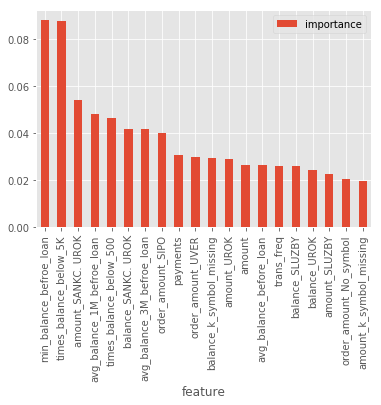

In [119]:

importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:20].plot(x="feature", y="importance", kind="bar")

### Visualization and feature selection

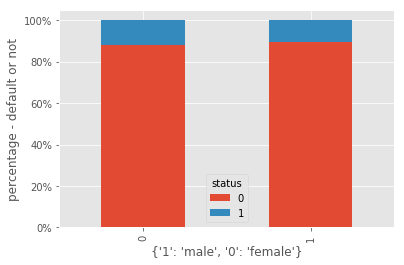

In [120]:

df.groupby(["sex", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)
plt.xlabel({"1": "male", "0": "female"})
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.show()

In [121]:
df.groupby(["sex", "status"])["status"].size()

sex  status
0    0         307
     1          41
1    0         299
     1          35
Name: status, dtype: int64

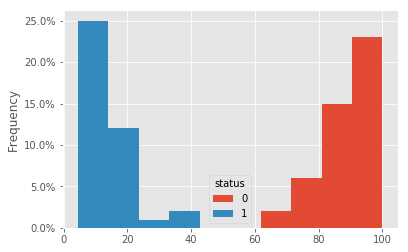

In [122]:
df.groupby(["age", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="hist", stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

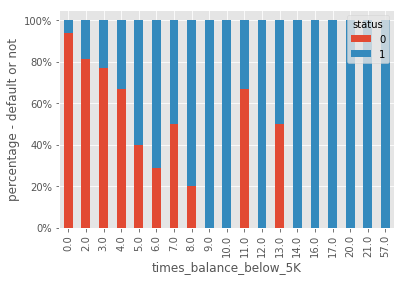

In [123]:
df.groupby(["times_balance_below_5K", "status"])["status"].size().groupby(
    level=0
).apply(lambda x: 100 * x / x.sum()).unstack().plot(kind="bar", stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.show()

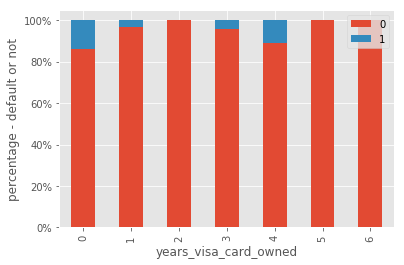

In [124]:

df.groupby(["years_card_issued", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.ylabel("percentage - default or not")
plt.xlabel("years_visa_card_owned")
plt.legend(loc=1)
plt.show()

Text(0,0.5,'count_of_loan_id')

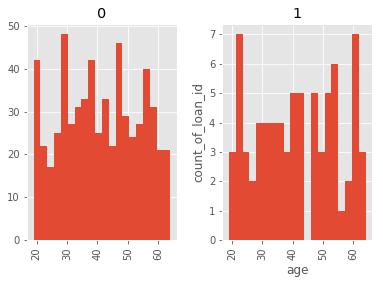

In [125]:
df.hist(column="age", by="status", bins=20)
plt.xlabel("age")
plt.ylabel("count_of_loan_id")

In [126]:
# create a érsonalized Binning:
def binning(col, cut_points, labels=None):
    # Define min and max values:
    minval = col.min()
    maxval = col.max()

    # create list by adding min and max to cut_points
    break_points = [minval] + cut_points + [maxval]

    # if no labels provided, use default labels 0 ... (n-1)
    if not labels:
        labels = range(len(cut_points) + 1)

    # Binning using cut function of pandas
    colBin = pd.cut(col, bins=break_points, labels=labels, include_lowest=True)
    return colBin


# Binning age:
cut_points = [24, 34, 44, 50]
labels = ["20", "25", "35", "45", "50"]
df["age_bin"] = binning(df["age"], cut_points, labels)

Text(0,0.5,'percentage - default or not')

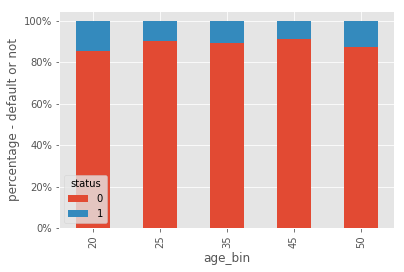

In [127]:
df.groupby(["age_bin", "status"])["status"].size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind="bar", stacked=True)

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())

plt.ylabel("percentage - default or not")

In [128]:
df[df.status == 1].head()

,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,min_balance_befroe_loan,avg_amount_trans_before_loan,avg_balance_before_loan,...,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing,years_of_loan,years_of_account,years_card_issued,age_bin
203,96396,12,8033.0,1,15966.666667,20100.000000,4,1100.0,5025.000000,12250.000000,...,0.0,0.000000,0.000000,0.000000,0.0,12250.000000,6,6,0,50
204,49320,12,4110.0,1,44874.806452,40374.653846,49,900.0,10548.359184,46576.277551,...,0.0,3764.867347,5225.602041,5311.316327,0.0,32274.491837,5,6,0,50
205,76908,12,6409.0,1,48022.006667,45030.575000,102,1100.0,12928.499020,52890.403922,...,0.0,0.000000,5553.810784,7347.900000,0.0,39988.693137,5,6,0,50
206,68400,12,5700.0,1,27057.933333,23872.250000,14,800.0,7253.300000,31793.735714,...,0.0,0.000000,0.000000,11144.471429,0.0,20649.264286,4,5,0,20
207,30276,12,2523.0,1,28364.893750,30449.380952,92,1000.0,5028.045652,31318.872826,...,0.0,1597.265217,2523.634783,12991.828261,0.0,14206.144565,3,4,0,50


In [129]:
df[df.status == 1].shape

(76, 51)

Text(0,0.5,'payments')

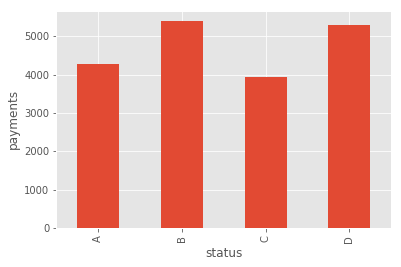

In [130]:
a = loan.groupby(
    by="status", axis=0, level=None, as_index=True, sort=True, group_keys=True
)
a.payments.mean().plot(kind="bar")
plt.ylabel("payments")

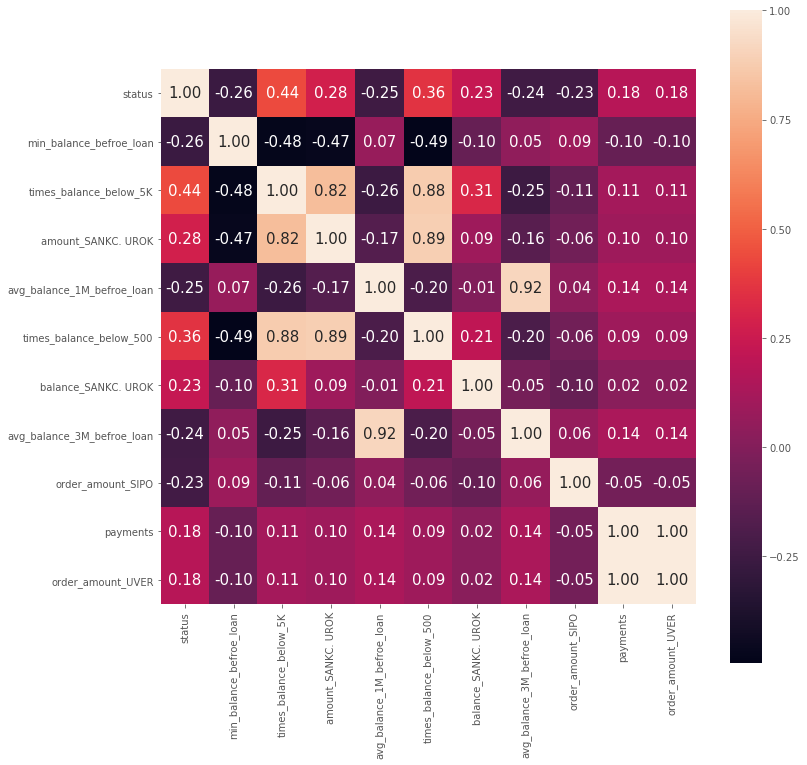

In [131]:

# plot heatmap
import seaborn as sns

cols = list(importance.feature[:10])
cols.insert(0, "status")
corrcoef_map = np.corrcoef(df[cols].values.T)
fig, ax = plt.subplots(figsize=(12, 12))  # Sample figsize in inches
hm = sns.heatmap(
    corrcoef_map,
    cbar=True,
    annot=True,
    square=True,
    fmt=".2f",
    annot_kws={"size": 15},
    yticklabels=cols,
    xticklabels=cols,
    ax=ax,
)

### Create X, y, training/testing set split
After identify relevant variables launch other models

In [132]:
#set seed for reproducibility
np.random.seed(201909) 

In [133]:
X = df.loc[:, df.columns != "status"]
y = df.loc[:, "status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [134]:
X_train.head()

,amount,duration,payments,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,min_balance_befroe_loan,avg_amount_trans_before_loan,avg_balance_before_loan,times_balance_below_500,...,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing,years_of_loan,years_of_account,years_card_issued,age_bin
535,285600,60,4760.0,50675.643478,38214.162500,49,1100.0,10411.720408,49651.891837,0.0,...,0.000000,0.000000,6459.908163,6893.338776,0.0,36298.644898,4,5,0,20
18,82896,12,6908.0,68508.656250,60469.207143,126,900.0,10765.977778,57141.730952,0.0,...,0.000000,5383.334127,3880.842857,6810.870635,0.0,34681.738095,5,6,5,25
23,71460,12,5955.0,42440.155556,46179.450000,43,200.0,10433.439535,47991.530233,0.0,...,0.000000,3505.597674,4942.155814,10301.141860,0.0,29242.634884,5,6,0,50
412,73056,48,1522.0,21800.567742,21044.000000,51,500.0,2445.327451,23255.149020,0.0,...,0.000000,1868.707843,2617.923529,4329.325490,0.0,14439.192157,4,4,0,25
673,293880,60,4898.0,6300.347059,3282.620000,90,-2804.8,11288.745556,53227.144444,6.0,...,-31.164444,0.000000,6663.210000,8483.168889,0.0,38111.930000,2,4,1,20


In [135]:
rf = ensemble.RandomForestClassifier(
    n_estimators=800,
    criterion="gini",
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features="auto",
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=1,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [136]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.94      0.99      0.96       184
          1       0.82      0.43      0.56        21

avg / total       0.93      0.93      0.92       205



In [137]:
fi = rf.feature_importances_

In [138]:

feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols, "importance": rf.feature_importances_}
)

Text(0,0.5,'importance')

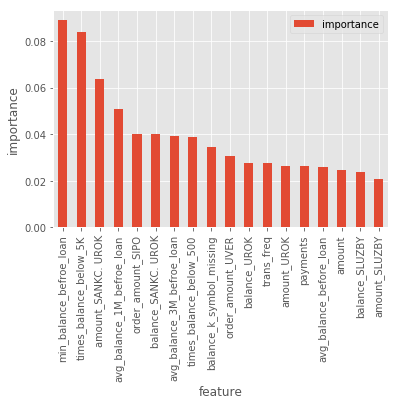

In [139]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:18].plot(x="feature", y="importance", kind="bar")
plt.ylabel("importance")

### Decision Tree

In [142]:
clf = tree.DecisionTreeClassifier(
    criterion="gini",
    splitter="best",
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=None,
    random_state=None,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    class_weight=None,
    presort=False,
)

model = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [143]:

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       184
          1       0.64      0.67      0.65        21

avg / total       0.93      0.93      0.93       205



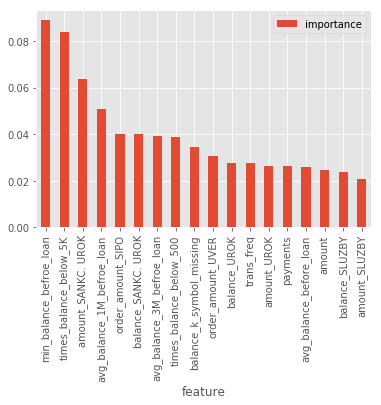

In [144]:

feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:18].plot(x="feature", y="importance", kind="bar")

### Gradient Boosting Classifier

In [146]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier(
    loss="deviance",
    learning_rate=0.1,
    n_estimators=200,
    subsample=1.0,
    criterion="friedman_mse",
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=3,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    init=None,
    random_state=None,
    max_features=None,
)
model = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [147]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.95      0.99      0.97       184
          1       0.92      0.57      0.71        21

avg / total       0.95      0.95      0.95       205



### Feature Scaling - for SVM & Logistic Regression


In [148]:
sc = StandardScaler()
X.drop(['age_bin'], axis=1, inplace=True)
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

/opt/conda/anaconda/lib/python3.6/site-packages/pandas/core/frame.py:4097: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


### SVM

In [149]:
svc = svm.SVC(
    C=5,
    kernel="rbf",
    degree=3,
    gamma="auto",
    coef0=0.0,
    shrinking=True,
    probability=False,
    tol=0.001,
    cache_size=200,
    class_weight=None,
    verbose=False,
    max_iter=-1,
    decision_function_shape="ovr",
    random_state=None,
)
model = svc.fit(X_train, y_train)

y_pred = svc.predict(X_test)

In [150]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.94      0.98      0.96       181
          1       0.76      0.54      0.63        24

avg / total       0.92      0.93      0.92       205



### Logistic Regression

In [151]:
lr = LogisticRegression(penalty="l1", C=1).fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [152]:

print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.93      0.96      0.94       181
          1       0.59      0.42      0.49        24

avg / total       0.89      0.90      0.89       205



### Try: Use only two features **to plot Decision Boundary

In [153]:
def plot_decision_boundary(model, X, y):
    X_max = X.max(axis=0)
    X_min = X.min(axis=0)
    xticks = np.linspace(X_min[0], X_max[0], 100)
    yticks = np.linspace(X_min[1], X_max[1], 100)
    xx, yy = np.meshgrid(xticks, yticks)
    ZZ = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = ZZ >= 0.5
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots()
    ax = plt.gca()
    ax.contourf(xx, yy, Z, cmap=plt.cm.PRGn, alpha=0.6)
    ax.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, alpha=0.6)

In [154]:
X = df[["min_balance_befroe_loan", "times_balance_below_5K"]]
y = df["status"]

In [155]:
rf = ensemble.RandomForestClassifier(
    n_estimators=500,
    criterion="gini",
    max_depth=4,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features="auto",
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=1,
    random_state=None,
    verbose=0,
    warm_start=False,
    class_weight=None,
)

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
model = rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
f1 = f1_score(y_pred, y_test)
f1

0.5

In [157]:
print(classification_report(y_test, y_pred))

             precision    recall  f1-score   support

          0       0.93      1.00      0.96       153
          1       1.00      0.33      0.50        18

avg / total       0.93      0.93      0.91       171



Text(0,0.5,'times_balance_below_5K')

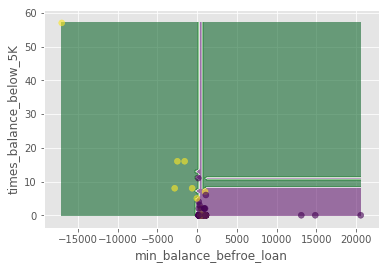

In [159]:
plot_decision_boundary(model, X_test, y_test)
plt.xlabel("min_balance_befroe_loan")
plt.ylabel("times_balance_below_5K")

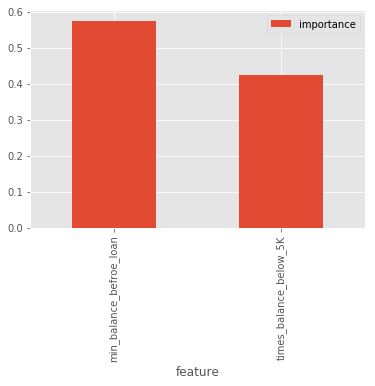

In [160]:
feature_cols = X_test.columns
importance = pd.DataFrame(
    {"feature": feature_cols[:], "importance": rf.feature_importances_[:]}
)
importance.sort_values(
    by="importance",
    axis=0,
    ascending=False,
    inplace=True,
    kind="quicksort",
    na_position="last",
)
importance[:18].plot(x="feature", y="importance", kind="bar")

### Conclusion
In the bank loan default prediction, my assumption is banks want to control the loss to a acceptable level, without missing some good client. This means balance the customers be grouped as potential good/bad customers, and their profiles will be checked carefully. Banks can detect the default behaviours in the earlier stage and conduct the corresponding actions to reduce the possible loss. That's why all of the new features I created are only based on the dates of the transfer must before the date that client apply for a loan.

In [161]:

#from google.cloud import bigquery
import pandas

In [ ]:
#%load_ext google.cloud.bigquery
#df.to_gbq(full_table_id, project_id=project_id)

In [162]:
df = pandas.DataFrame(
    {
        'my_string': ['a', 'b', 'c'],
        'my_int64': [1, 2, 3],
        'my_float64': [4.0, 5.0, 6.0],
    }
)
full_table_id = 'lamdatacrew_clean_data.new_table_test2'
project_id = 'hsbc-datathon-sandbox'

df.to_gbq(full_table_id, project_id=project_id)

In [163]:
%%bigquery new_table_test2
select * from `lamdatacrew_clean_data.new_table_test2`; 

In [164]:
new_table_test2.head()

,my_string,my_int64,my_float64
0,a,1,4.0
1,b,2,5.0
2,c,3,6.0


In [165]:
df = pd.read_csv("/home/dfdataset.csv", header="infer")

df.info()

In [168]:
#df.drop(["issued","A12","A15"], axis=1, inplace=True)
df.head()

,Unnamed: 0,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,min_balance_befroe_loan,avg_amount_trans_before_loan,...,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing,years_of_loan,years_of_account,years_card_issued
0,0,52788,12,4399.0,0,20615.732000,20471.962500,43,1000.0,3714.897674,...,0.000000,0.0,1896.844186,1297.981395,3675.248837,0.0,15328.104651,6,6,0
1,1,47016,12,3918.0,0,69408.845833,66679.309091,42,200.0,12252.223810,...,0.000000,0.0,6294.657143,7246.014286,10610.833333,0.0,36230.580952,6,6,0
2,2,38148,12,3179.0,0,41406.252632,36175.655556,29,900.0,8369.555172,...,3203.531034,0.0,853.648276,1232.855172,11959.148276,0.0,20212.910345,6,6,0
3,3,86616,12,7218.0,0,29641.558333,36958.900000,15,800.0,5323.546667,...,0.000000,0.0,0.000000,0.000000,9780.620000,0.0,15933.426667,6,6,0
4,4,24516,12,2043.0,0,69396.845161,63994.557143,73,200.0,16201.558904,...,0.000000,0.0,0.000000,5497.987671,6616.652055,0.0,43467.586301,5,6,0


In [176]:
#df.drop(["birth_number", "month", "year"], axis=1, inplace=True)
df["amount"].shape
df.drop(["Unnamed: 0"], axis=1, inplace=True)

In [177]:
df.head()

,amount,duration,payments,status,avg_balance_3M_befroe_loan,avg_balance_1M_befroe_loan,trans_freq,min_balance_befroe_loan,avg_amount_trans_before_loan,avg_balance_before_loan,...,balance_POJISTNE,balance_SANKC. UROK,balance_SIPO,balance_SLUZBY,balance_UROK,balance_UVER,balance_k_symbol_missing,years_of_loan,years_of_account,years_card_issued
0,52788,12,4399.0,0,20615.732000,20471.962500,43,1000.0,3714.897674,22198.179070,...,0.000000,0.0,1896.844186,1297.981395,3675.248837,0.0,15328.104651,6,6,0
1,47016,12,3918.0,0,69408.845833,66679.309091,42,200.0,12252.223810,60382.085714,...,0.000000,0.0,6294.657143,7246.014286,10610.833333,0.0,36230.580952,6,6,0
2,38148,12,3179.0,0,41406.252632,36175.655556,29,900.0,8369.555172,37462.093103,...,3203.531034,0.0,853.648276,1232.855172,11959.148276,0.0,20212.910345,6,6,0
3,86616,12,7218.0,0,29641.558333,36958.900000,15,800.0,5323.546667,25714.046667,...,0.000000,0.0,0.000000,0.000000,9780.620000,0.0,15933.426667,6,6,0
4,24516,12,2043.0,0,69396.845161,63994.557143,73,200.0,16201.558904,55582.226027,...,0.000000,0.0,0.000000,5497.987671,6616.652055,0.0,43467.586301,5,6,0


In [179]:
df.shape

(682, 50)

In [180]:
full_table_id = 'lamdatacrew_clean_data.data_fe_loan_default'
project_id = 'hsbc-datathon-sandbox'

df.to_gbq(full_table_id, project_id=project_id)

GenericGBQException: Reason: 400 POST https://bigquery.googleapis.com/bigquery/v2/projects/hsbc-datathon-sandbox/datasets/lamdatacrew_clean_data/tables: Invalid field name "amount_SANKC. UROK". Fields must contain only letters, numbers, and underscores, start with a letter or underscore, and be at most 128 characters long.

In [181]:
df.columns

Index(['amount', 'duration', 'payments', 'status',
       'avg_balance_3M_befroe_loan', 'avg_balance_1M_befroe_loan',
       'trans_freq', 'min_balance_befroe_loan', 'avg_amount_trans_before_loan',
       'avg_balance_before_loan', 'times_balance_below_500',
       'times_balance_below_5K', 'frequency', 'order_amount_LEASING',
       'order_amount_No_symbol', 'order_amount_POJISTNE', 'order_amount_SIPO',
       'order_amount_UVER', 'type', 'age', 'sex', 'A1', 'A4', 'A5', 'A6', 'A7',
       'A8', 'A9', 'A10', 'A11', 'A13', 'A14', 'A16', 'amount_POJISTNE',
       'amount_SANKC. UROK', 'amount_SIPO', 'amount_SLUZBY', 'amount_UROK',
       'amount_UVER', 'amount_k_symbol_missing', 'balance_POJISTNE',
       'balance_SANKC. UROK', 'balance_SIPO', 'balance_SLUZBY', 'balance_UROK',
       'balance_UVER', 'balance_k_symbol_missing', 'years_of_loan',
       'years_of_account', 'years_card_issued'],
      dtype='object')

In [182]:
df.rename(
    index=None,
    columns={
        "amount_SANKC. UROK": "amount_SANKC_UROK",
        "balance_SANKC. UROK": "balance_SANKC_UROK"
    },
    inplace=True,
)

In [183]:
df.columns

Index(['amount', 'duration', 'payments', 'status',
       'avg_balance_3M_befroe_loan', 'avg_balance_1M_befroe_loan',
       'trans_freq', 'min_balance_befroe_loan', 'avg_amount_trans_before_loan',
       'avg_balance_before_loan', 'times_balance_below_500',
       'times_balance_below_5K', 'frequency', 'order_amount_LEASING',
       'order_amount_No_symbol', 'order_amount_POJISTNE', 'order_amount_SIPO',
       'order_amount_UVER', 'type', 'age', 'sex', 'A1', 'A4', 'A5', 'A6', 'A7',
       'A8', 'A9', 'A10', 'A11', 'A13', 'A14', 'A16', 'amount_POJISTNE',
       'amount_SANKC_UROK', 'amount_SIPO', 'amount_SLUZBY', 'amount_UROK',
       'amount_UVER', 'amount_k_symbol_missing', 'balance_POJISTNE',
       'balance_SANKC_UROK', 'balance_SIPO', 'balance_SLUZBY', 'balance_UROK',
       'balance_UVER', 'balance_k_symbol_missing', 'years_of_loan',
       'years_of_account', 'years_card_issued'],
      dtype='object')

In [184]:
full_table_id = 'lamdatacrew_clean_data.data_fe_loan_default'
project_id = 'hsbc-datathon-sandbox'

df.to_gbq(full_table_id, project_id=project_id)